computing hourly data...done.


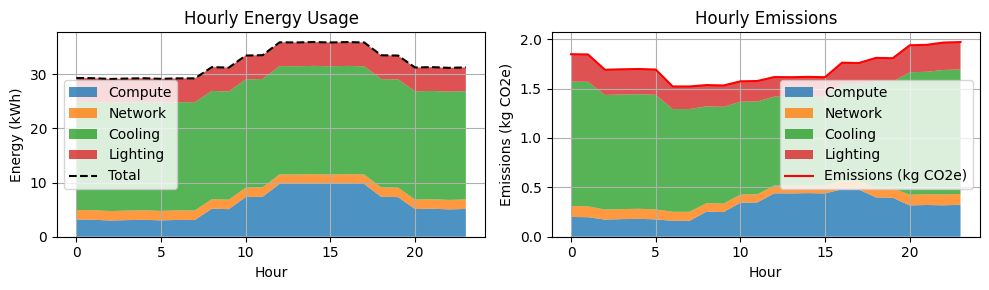

computing hourly data...done.


computing hourly data...done.


computing hourly data...done.


computing hourly data...done.


In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import random

%matplotlib inline

class Load:
    # For now, sinusoidal time-varying server load model with peak in the afternoon.
    # Load between 0 and 1, in 2-hour intervals starting at 0:00-1:59.
    load_by_hours = [
        0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 0.8, 0.6, 0.6
    ]

    @staticmethod
    def at_hour(hour):
        assert 0 <= hour < 24
        return max(0, min(Load.load_by_hours[hour // 2] + random.uniform(-0.1, 0.1), 1))

class Emissions:
    # Average direct (not including LCA) emissions factors in g CO2e per kWh
    # for electricity consumed in Switzerland for each pair of hours starting
    # with 0:00-1:59, based on hourly data for 2023 from https://electricitymaps.com/.
    gco2_per_kwh_by_hours = [
        63, 58, 58, 52, 49, 47, 45, 45, 49, 54, 62, 63,
    ]

    @staticmethod
    def at_hour(hour):
        return Emissions.gco2_per_kwh_by_hours[hour // 2]

    @staticmethod
    def average():
        return sum(Emissions.gco2_per_kwh_by_hours) / 12

class Server:
    def __init__(self, power_w):
        self.power_w = power_w

    def power_at_hour(self, hour):
        l = Load.at_hour(hour)
        return self.power_w * (0.6 * l + 0.4 * l * l)

    def energy_and_emissions(self, start_hour, end_hour):
        # Integrate power and emissions over time based on load and emissions models.
        assert 0 <= start_hour < 24 and 0 <= end_hour < 24
        wh, gco2e = 0, 0
        for hour in range(start_hour, end_hour + 1):
            p = self.power_at_hour(hour)
            wh += p
            gco2e += Emissions.at_hour(hour) * p / 1000
        return wh, gco2e

class NetworkGear:
    def __init__(self, power_w):
        self.power_w = power_w

    def energy_and_emissions(self, start_hour, end_hour):
        assert 0 <= start_hour < 24 and 0 <= end_hour < 24
        # No load factor because power utilization at >10% load is ~= power utilization at 100% load.
        wh = self.power_w * (end_hour - start_hour + 1)
        gco2e = 0
        for hour in range(start_hour, end_hour + 1):
            gco2e += Emissions.at_hour(hour) * self.power_w / 1000
        return wh, gco2e

class DataCenter:
    def __init__(self, servers, network_gear, cooling_power_kw, lighting_power_kw):
        self.servers = servers
        self.network_gear = network_gear
        self.cooling_power_kw = cooling_power_kw
        self.lighting_power_kw = lighting_power_kw
        self.fig, self.ax1, self.ax2 = None, None, None

    def energy_and_emissions(self, start_hour, end_hour):
        assert 0 <= start_hour < 24 and 0 <= end_hour < 24

        self.compute_kwh, compute_gco2e = 0, 0
        for server in self.servers:
            energy, emissions = server.energy_and_emissions(start_hour, end_hour)
            self.compute_kwh += energy
            compute_gco2e += emissions
        self.compute_kwh /= 1000  # Convert Wh to kWh

        network_kwh, network_gco2e = 0, 0
        for gear in self.network_gear:
            energy, emissions = gear.energy_and_emissions(start_hour, end_hour)
            network_kwh += energy
            network_gco2e += emissions
        network_kwh /= 1000  # Convert Wh to kWh

        cooling_kwh = self.cooling_power_kw * (end_hour - start_hour + 1)
        cooling_gco2e = Emissions.average() * cooling_kwh
        lighting_kwh = self.lighting_power_kw * (end_hour - start_hour + 1)
        lighting_gco2e = Emissions.average() * lighting_kwh

        self.total_kwh = self.compute_kwh + network_kwh + cooling_kwh + lighting_kwh
        self.total_kgco2e = (compute_gco2e + network_gco2e + cooling_gco2e + lighting_gco2e) / 1000
        return self.total_kwh, self.total_kgco2e

    def hourly_energy_and_emissions(self, start_hour, end_hour):
        assert 0 <= start_hour < 24 and 0 <= end_hour < 24
        print("computing hourly data...", end="")
        self.compute_kwh, self.total_kwh, self.total_kgco2e = 0, 0, 0
        hourly_data = []
        for hour in range(start_hour, end_hour + 1):
            compute_kwh, compute_kgco2e = 0, 0
            for server in self.servers:
                energy, emissions = server.energy_and_emissions(hour, hour)
                compute_kwh += energy / 1000  # Convert Wh to kWh
                compute_kgco2e += emissions / 1000

            network_kwh, network_kgco2e = 0, 0
            for gear in self.network_gear:
                energy, emissions = gear.energy_and_emissions(hour, hour)
                network_kwh += energy / 1000
                network_kgco2e += emissions / 1000

            # TODO: consider refinement to cooling model. E.g.,Cooling Power = Baseline + IT Energy × Cooling Factor.
            # However, probably easier to obtain total cooling power than cooling factor.
            cooling_kwh = self.cooling_power_kw
            cooling_kgco2e = Emissions.at_hour(hour) * cooling_kwh / 1000
            lighting_kwh = self.lighting_power_kw
            lighting_kgco2e = Emissions.at_hour(hour) * lighting_kwh / 1000

            total_kwh = compute_kwh + network_kwh + cooling_kwh + lighting_kwh
            total_kgco2e = compute_kgco2e + network_kgco2e + cooling_kgco2e + lighting_kgco2e

            self.compute_kwh += compute_kwh
            self.total_kwh += total_kwh
            self.total_kgco2e += total_kgco2e

            hourly_data.append({
                'hour': hour,
                'compute_kwh': compute_kwh,
                'compute_gco2e': compute_kgco2e,
                'network_kwh': network_kwh,
                'network_gco2e': network_kgco2e,
                'cooling_kwh': cooling_kwh,
                'cooling_gco2e': cooling_kgco2e,
                'lighting_kwh': lighting_kwh,
                'lighting_gco2e': lighting_kgco2e,
                'total_kwh': total_kwh,
                'total_kgco2e': total_kgco2e
            })
        print("done.")
        return hourly_data

    def pue(self):
        return self.total_kwh / self.compute_kwh if self.compute_kwh > 0 else float('inf')
    
    def cue(self):
        return self.total_kgco2e / self.compute_kwh if self.total_kgco2e > 0 else float('inf')

servers = (
    [Server(100) for _ in range(1000)] +
    [Server(500) for _ in range(100)] +
    [Server(1000) for _ in range(20)]
)
network_gear = (
    [NetworkGear(70) for _ in range(25)] +
    [NetworkGear(90) for _ in range(5)]
)

cooling_power_kw = 20  # Cooling system power consumption in kW
lighting_power_kw = 1  # Lighting power consumption in kW
data_center = DataCenter(servers, network_gear, cooling_power_kw, lighting_power_kw)

server_type_dropdown = widgets.Dropdown(options=['100W', '500W', '1000W'], value='100W', description='Server Type:')
server_count_slider = widgets.IntSlider(value=100, min=1, max=1000, step=10, description='Count:')
network_type_dropdown = widgets.Dropdown(options=['70W', '90W'], value='70W', description='Gear Type:')
network_count_slider = widgets.IntSlider(value=25, min=1, max=50, step=1, description='Count:')
cooling_power_slider = widgets.FloatSlider(value=20, min=0, max=50, step=1, description='Cooling (kW):')
lighting_power_slider = widgets.FloatSlider(value=1, min=0, max=10, step=0.1, description='Lighting (kW):')
start_hour_slider = widgets.IntSlider(value=0, min=0, max=23, step=1, description='Start Hour:')
end_hour_slider = widgets.IntSlider(value=23, min=0, max=23, step=1, description='End Hour:')
graphs = widgets.Output(layout={'border': '1px solid black'})
info_text = widgets.Textarea(value='', layout=widgets.Layout(width='80%', height='200px'))
update_button = widgets.Button(description='Update',button_style='success')
fig, ax1, ax2 = None, None, None

server_box = widgets.VBox([server_type_dropdown, server_count_slider])
gear_box = widgets.VBox([network_type_dropdown, network_count_slider])
cooling_lighting_box = widgets.VBox([cooling_power_slider, lighting_power_slider])
time_box = widgets.HBox([start_hour_slider, end_hour_slider])
main_box = widgets.VBox([server_box, gear_box, cooling_lighting_box, time_box, update_button, graphs, info_text])
display(main_box)

def update(b):
    plt.ioff()
    server_power = int(server_type_dropdown.value.rstrip('W'))
    servers = [Server(server_power) for _ in range(server_count_slider.value)]
    network_power = int(network_type_dropdown.value.rstrip('W'))
    network_gear = [NetworkGear(network_power) for _ in range(network_count_slider.value)]
    baseline_cooling_kw = cooling_power_slider.value
    lighting_power_kw = lighting_power_slider.value
    start_hour = start_hour_slider.value
    end_hour = end_hour_slider.value
    data_center.servers = servers
    data_center.network_gear = network_gear
    data_center.cooling_power_kw = baseline_cooling_kw
    data_center.lighting_power_kw = lighting_power_kw
    hourly_data = data_center.hourly_energy_and_emissions(start_hour, end_hour)

    hours = [data['hour'] for data in hourly_data]
    compute_kwh = [data['compute_kwh'] for data in hourly_data]
    compute_kgco2e = [data['compute_gco2e'] for data in hourly_data]
    network_kwh = [data['network_kwh'] for data in hourly_data]
    network_kgco2e = [data['network_gco2e'] for data in hourly_data]
    cooling_kwh = [data['cooling_kwh'] for data in hourly_data]
    cooling_kgco2e = [data['cooling_gco2e'] for data in hourly_data]
    lighting_kwh = [data['lighting_kwh'] for data in hourly_data]
    lighting_kgco2e = [data['lighting_gco2e'] for data in hourly_data]
    total_kwh = [data['total_kwh'] for data in hourly_data]
    total_emissions = [data['total_kgco2e'] for data in hourly_data]

    global fig, ax1, ax2
    if fig is None or ax1 is None or ax2 is None:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    ax1.clear()
    ax1.stackplot(hours, compute_kwh, network_kwh, cooling_kwh, lighting_kwh, 
                    labels=['Compute', 'Network', 'Cooling', 'Lighting'], alpha=0.8)
    ax1.plot(hours, total_kwh, color='black', linestyle='--', label='Total')
    ax1.set_title("Hourly Energy Usage")
    ax1.set_xlabel("Hour")
    ax1.set_ylabel("Energy (kWh)")
    ax1.legend()
    ax1.grid(True)

    ax2.clear()
    ax2.stackplot(hours, compute_kgco2e, network_kgco2e, cooling_kgco2e, lighting_kgco2e, 
                    labels=['Compute', 'Network', 'Cooling', 'Lighting'], alpha=0.8)
    ax2.plot(hours, total_emissions, label='Emissions (kg CO2e)', color='red')
    ax2.set_title("Hourly Emissions")
    ax2.set_xlabel("Hour")
    ax2.set_ylabel("Emissions (kg CO2e)")
    ax2.legend()
    ax2.grid(True)
    fig.tight_layout()

    with graphs:
        display(fig, clear=True)

    info_text.value = (
        f"Number of servers: {len(servers)}\n"
        f"IT energy consumption for one day: {data_center.compute_kwh:.2f} kWh\n"
        f"Total energy consumption for one day: {data_center.total_kwh:.2f} kWh\n"
        f"Total emissions for one day: {data_center.total_kgco2e:.2f} kg CO2e\n"
        f"PUE: {data_center.pue():.2f}\n"
        f"CUE: {data_center.cue():.2f} kg CO2e/kWh"
    )

update_button.on_click(update)
update(None)
